# Fashion Recommendation System

## Embedding model - SqueezeNet

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
%matplotlib inline

In [2]:
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Sat Nov 27 00:26:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P8     8W / 180W |    250MiB /  8116MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   54C    P8     6W / 180W |     12MiB /  8119MiB |      0%      Default |
+-------------------------------+---------------

## Data Preprocessing

In [5]:
# Processing meta data
category_list = []
image_path_list = []
data_type_list = []
# category names
with open('/media/pavan/datasets/deepfashion/Anno/list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category map
with open('/media/pavan/datasets/deepfashion/Anno/list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# train, valid, test
with open('/media/pavan/datasets/deepfashion/Eval/list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [6]:
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)
data_df.head()

,image_path,dataset_type,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test,Blouse


In [7]:
len(data_df)

289222

In [8]:
data_df[['image_path','dataset_type']].groupby('dataset_type').count()

,image_path
dataset_type,
test,40000
train,209222
val,40000


In [9]:
len(data_df.category.unique())

46

In [10]:
data_df[['image_path','category']].groupby('category').count()

,image_path
category,
Anorak,160
Blazer,7495
Blouse,24557
Bomber,309
Button-Down,330
Caftan,54
Capris,77
Cardigan,13311
Chinos,527


# Convert images to embeddings

/home/pavan/miniconda3/envs/torch191/lib/python3.9/site-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630797748/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


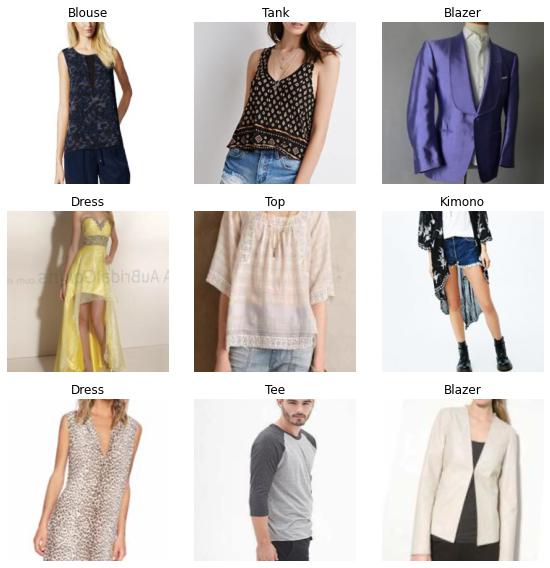

In [11]:
root_path = '/media/pavan/datasets/deepfashion/Img/'
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset_type']=='train'].index),
    (data_df[data_df['dataset_type']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=data_df[data_df['dataset_type'] == 'test'], path=root_path, cols='image_path')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

## Conduct Transfer Learning from SqueezeNet

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 1.20E-02


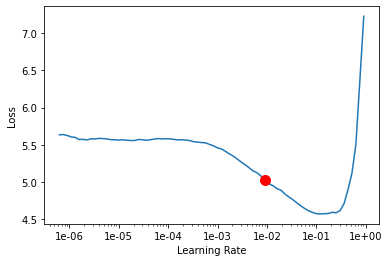

In [12]:
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

pretrained_model = models.squeezenet1_0

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

In [13]:
learner.fit_one_cycle(10, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.922924,1.688157,0.501875,0.501875,0.843300,06:41
1,1.840010,1.652480,0.513250,0.513250,0.850075,06:36
2,1.867666,1.642595,0.514525,0.514525,0.855500,06:37
3,1.830487,1.634299,0.518225,0.518225,0.853475,06:48
4,1.817478,1.605805,0.522475,0.522475,0.860075,06:41
5,1.791496,1.596012,0.522250,0.522250,0.859700,06:38
6,1.771126,1.569014,0.533500,0.533500,0.864625,06:37
7,1.714060,1.541753,0.543225,0.543225,0.870000,06:37
8,1.732022,1.527894,0.545375,0.545375,0.873250,06:37
9,1.715622,1.522294,0.547875,0.547875,0.874275,06:37


## Evaluate Model 

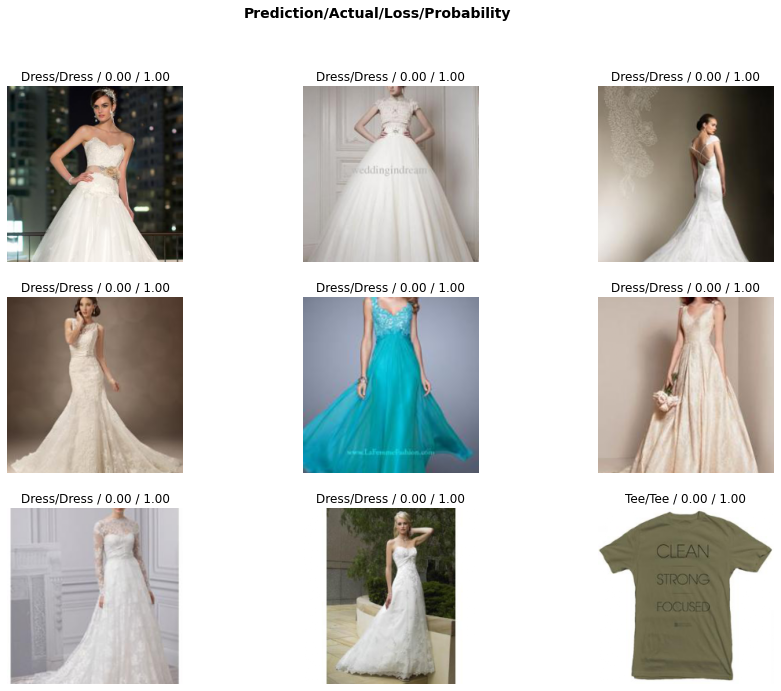

In [14]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

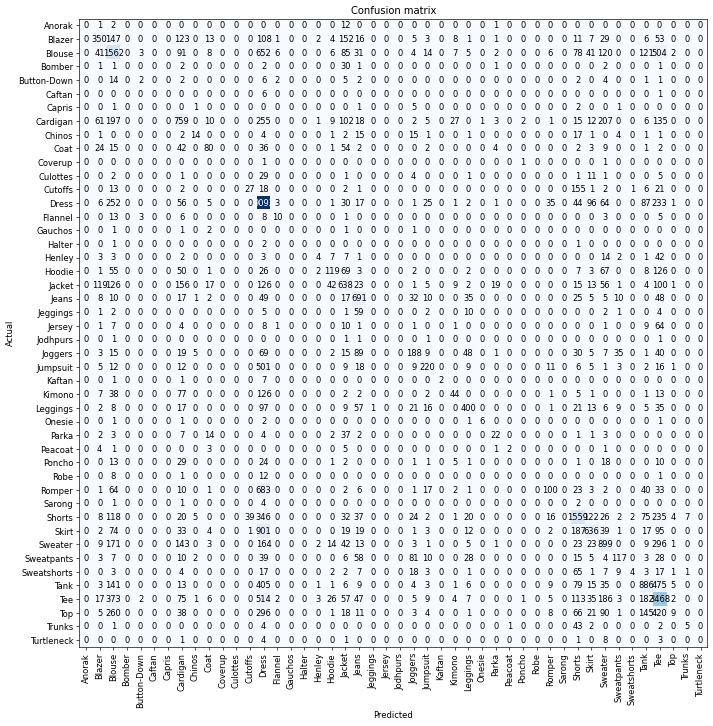

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
learner.save('/home/pavan/code/sjsu/256/project/shufflenet-fashion')

In [18]:
learner.model.module

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activa

# Use Fastai hooks to retrieve image embeddings

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [20]:
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

pretrained_model = models.squeezenet1_0 

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]


model_path = "/home/pavan/code/sjsu/256/project/shufflenet-fashion"
loaded_learner = load_learner(data, pretrained_model, model_metrics, model_path)

In [22]:
loaded_learner.model.module[-1][-3]

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [23]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(loaded_learner.model.module[-1][-3])
train_embed = loaded_learner.get_preds(data.train_ds)
val_embed = loaded_learner.get_preds(data.valid_ds)

In [24]:
saved_features.remove()

In [28]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})[:len(saved_features.features)]
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()
data_df_ouput

,img_path,label,label_id,embeddings
0,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[13.39670467376709, -15.265654563903809, 8.449..."
1,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[2.316887855529785, 8.911335945129395, -16.785..."
2,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[9.386387825012207, -29.719514846801758, -1.20..."
3,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[-24.028230667114258, -24.48685073852539, -9.3..."
4,/media/pavan/datasets/deepfashion/Img/img/Shee...,Blouse,2,"[25.272308349609375, -3.1631336212158203, 4.34..."
...,...,...,...,...
218049,/media/pavan/datasets/deepfashion/Img/img/Chic...,Top,43,"[-9.98422908782959, -31.44858741760254, 6.3152..."
218050,/media/pavan/datasets/deepfashion/Img/img/Chic...,Top,43,"[-27.76072120666504, 8.114909172058105, 27.257..."
218051,/media/pavan/datasets/deepfashion/Img/img/Chic...,Top,43,"[-33.375213623046875, -38.3443489074707, 2.415..."
218052,/media/pavan/datasets/deepfashion/Img/img/Chic...,Top,43,"[-13.810840606689453, -32.418025970458984, 14...."


# Use Approximate Nearest Neighbors to obtain most similar images

In [29]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 

def show_similar_images(similar_images_df, fig_size=[10,10], hide_labels=True):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            # replace category with blank so it wont show in display
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [30]:
# more tree = better approximation
ntree = 100
#"angular", "euclidean", "manhattan", "hamming", or "dot"
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# # takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

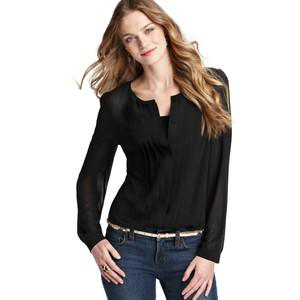

In [32]:
open_image(data_df_ouput.iloc[0, 0])

In [33]:
outfit_img_ids = [0]
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

_, _, similar_images_df = get_similar_images_annoy(annoy_tree, 0, 30)

1.100301742553711 ms


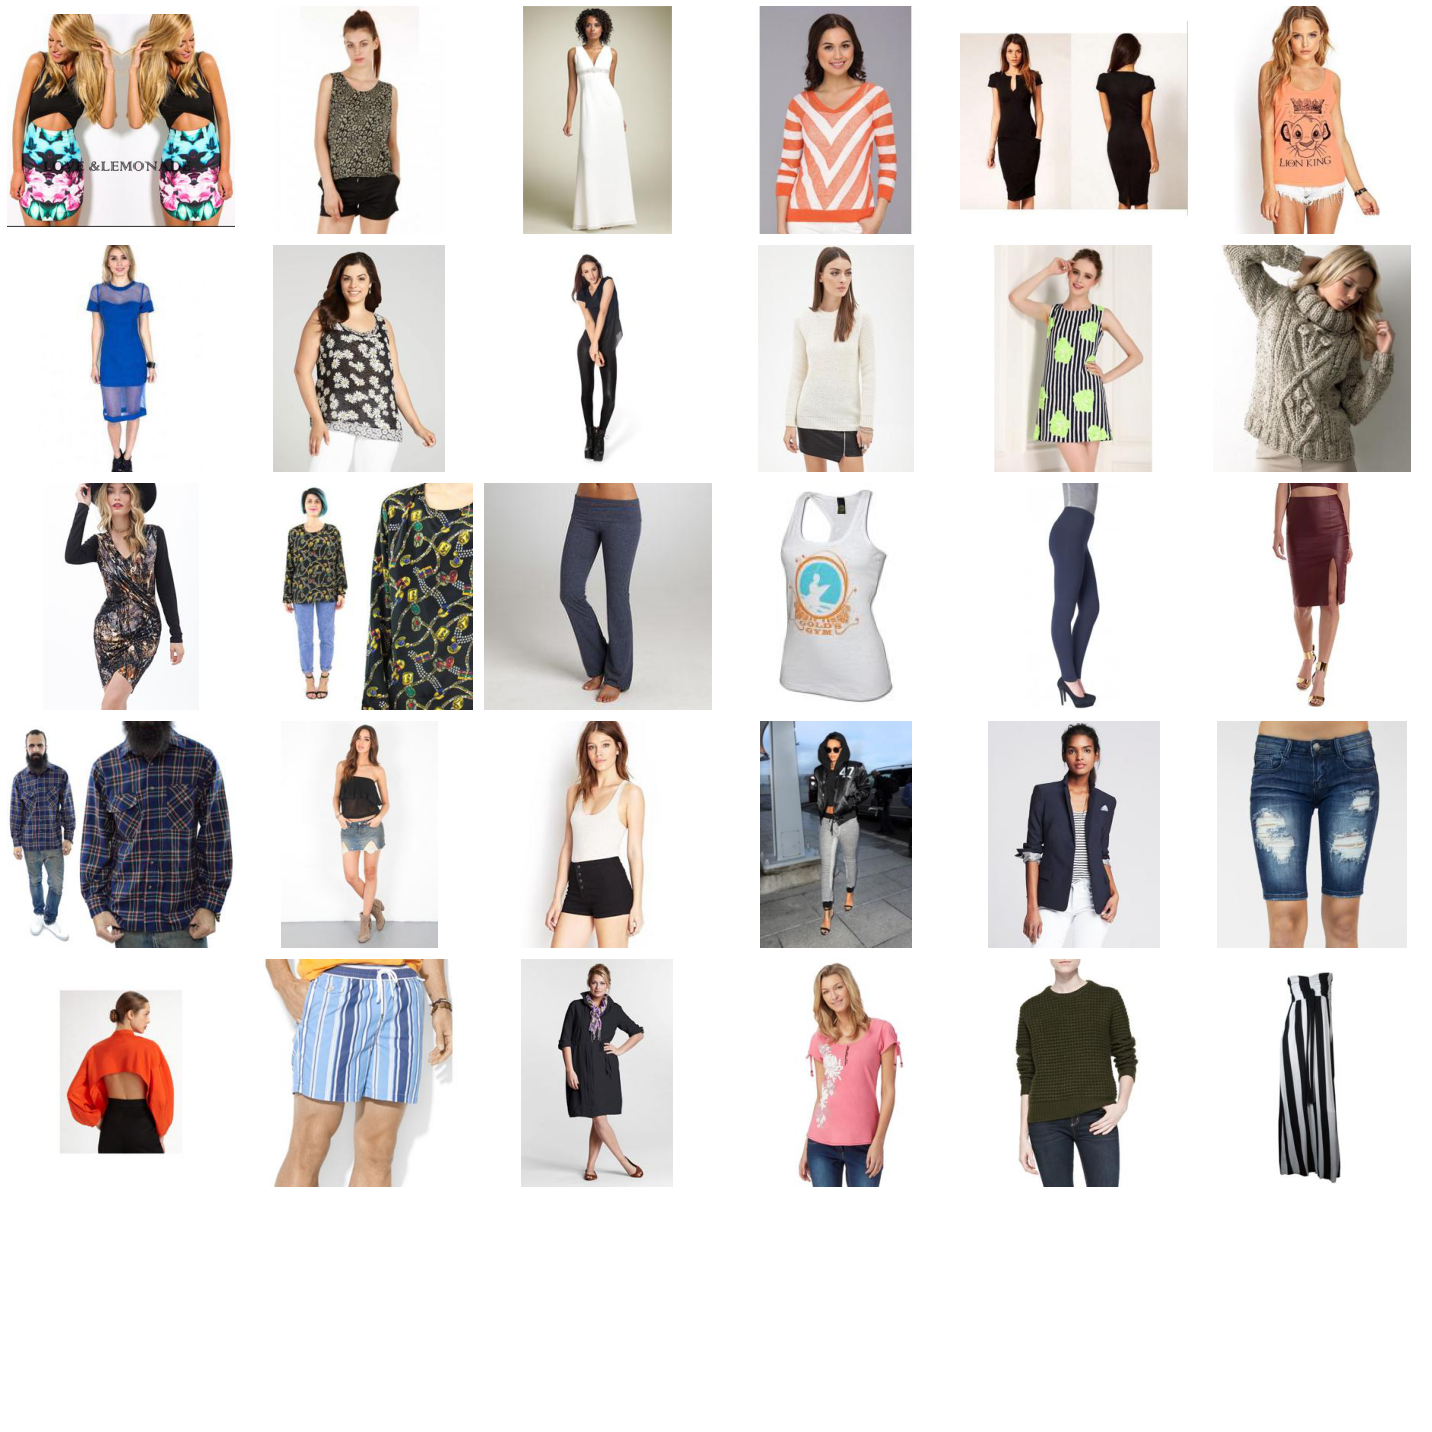

In [36]:
show_similar_images(similar_images_df, fig_size=[20,20])